In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir('/content/drive/MyDrive/project')

Mounted at /content/drive


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
import keras
from keras import backend as K
from keras.models import load_model, Model
from keras.layers import Flatten, Dense, Dropout, Activation, Input, LSTM, Reshape, Conv2D, MaxPooling2D, CuDNNLSTM
from keras.layers.advanced_activations import LeakyReLU
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint, EarlyStopping
from math import floor

from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# **Data Process**

In [ ]:
MSFT = pd.read_csv('MSFT.csv')
BILI = pd.read_csv('BILI.csv')
AAPL = pd.read_csv('AAPL.csv')

In [ ]:
# Purpose here: make our data into the form that can be feeded into the neural network

######### PART ONE : Some Auxiliary Function ##############
# a function to transform X and Y into rolling window of length 'T'
def data_classification(X, Y, T):
    [N, D] = X.shape
    df = np.array(X)
    dY = np.array(Y)
    dataY = dY[T : N]
    dataX = np.zeros((N - T, T, D))
    for i in range(T, N):
        dataX[i - T] = df[i - T:i, :]
    return dataX.reshape(dataX.shape + (1,)), dataY

# a function that will be used in the next 'normalizaiton_zscore' function
def rolling_window(a, window):
  shape = a.shape[:-1] + (a.shape[-1] - window + 1, window)
  strides = a.strides + (a.strides[-1],)
  return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)

#  a function that standardize data into z-score by the method of rolling window
def normalization_zscore(arr, window):
  arr=arr.T
  mean = np.mean(rolling_window(arr,window),-1)
  std = np.mean(rolling_window(arr,window),-1)
  arr1=arr[:,(window-1):]
  return ((arr1-mean)/std).T


######### PART TWO: Main Function for Data Preparation ##############

def prepare_x_y(df, stock, k, T, alpha=1e-05, normalization_window=5):

  # 'df' is the input data
  # 'stock' is the number code of the stock (e.g. 'MSFT' is '1')
  # 'k' is prediction horizon
  # 'T' is the length of a single input
  # 'alpha' is threshold of going up or down

  X = (df[df['Stock']==stock].iloc[:, 3:]).copy()
  list_columns=['PRICE_ASK_0','VOLUME_ASK_0','PRICE_BID_0','VOLUME_BID_0',
                'PRICE_ASK_1','VOLUME_ASK_1','PRICE_BID_1','VOLUME_BID_1',
                'PRICE_ASK_2','VOLUME_ASK_2','PRICE_BID_2','VOLUME_BID_2',
                'PRICE_ASK_3','VOLUME_ASK_3','PRICE_BID_3','VOLUME_BID_3',
                'PRICE_ASK_4','VOLUME_ASK_4','PRICE_BID_4','VOLUME_BID_4',
                'PRICE_ASK_5','VOLUME_ASK_5','PRICE_BID_5','VOLUME_BID_5',
                'PRICE_ASK_6','VOLUME_ASK_6','PRICE_BID_6','VOLUME_BID_6',
                'PRICE_ASK_7','VOLUME_ASK_7','PRICE_BID_7','VOLUME_BID_7',
                'PRICE_ASK_8','VOLUME_ASK_8','PRICE_BID_8','VOLUME_BID_8',
                'PRICE_ASK_9','VOLUME_ASK_9','PRICE_BID_9','VOLUME_BID_9']
  # only extract the columns listed above
  X=X[list_columns]
  X=X.reset_index(drop=True)

  # calculate the mid price of stock
  mid=(X['PRICE_ASK_0']+X['PRICE_BID_0'])/2
  
  # Here we smooth our data to label the price movement
  # m_minus is the mean of the previous k mid-price
  m_minus=mid.rolling(window = k).mean()
  for i in range(k-1):
    m_minus[i]=mid[:(i+1)].mean()
  
  # m_plus is the mean of the next k mid-price
  m_plus=m_minus.copy()
  m_plus[:(len(X)-k)]=m_plus[k:]
  for i in range(k):
    m_plus[len(X)-k+i]=mid[(len(X)-k+i):].mean()
  
  # l is the percentage change of smoothed mid-price
  l=(m_plus-m_minus)/m_minus
  Y=l.copy()
  Y[l<=-alpha] = 0  # stock price is going to decrease (red)
  Y[(l>-alpha)&(l<=alpha)] = 1  # stock price is going to be steady (white)
  Y[l>alpha] = 2  # stock price is going to increase (green)
  
  # Conduct the rolling normalize of X after labelling
  X=pd.DataFrame(normalization_zscore(np.array(X), normalization_window),columns=list_columns)

  # transform X and Y into rolling window of length 'T'
  X, Y = data_classification(X, Y, T=T)

  # change Y to the form of one-hot coding
  Y = np_utils.to_categorical(Y, 3)
  
  return mid, X, Y

# **Confusion Matrix and Boxplot for Model 1**

## **Define Model 1**

In [2]:
# Model1
def create_deeplob(T, NF, number_of_lstm):
    input_lmd = Input(shape=(T, NF, 1))
    
    # build the convolutional block
    conv_first1 = Conv2D(32, (1, 2), strides=(1, 2))(input_lmd)
    conv_first1 = keras.layers.LeakyReLU(alpha=0.01)(conv_first1)
    conv_first1 = Conv2D(32, (4, 1), padding='same')(conv_first1)
    conv_first1 = keras.layers.LeakyReLU(alpha=0.01)(conv_first1)
    conv_first1 = Conv2D(32, (4, 1), padding='same')(conv_first1)
    conv_first1 = keras.layers.LeakyReLU(alpha=0.01)(conv_first1)

    conv_first1 = Conv2D(32, (1, 2), strides=(1, 2))(conv_first1)
    conv_first1 = keras.layers.LeakyReLU(alpha=0.01)(conv_first1)
    conv_first1 = Conv2D(32, (4, 1), padding='same')(conv_first1)
    conv_first1 = keras.layers.LeakyReLU(alpha=0.01)(conv_first1)
    conv_first1 = Conv2D(32, (4, 1), padding='same')(conv_first1)
    conv_first1 = keras.layers.LeakyReLU(alpha=0.01)(conv_first1)

    conv_first1 = Conv2D(32, (1, 10))(conv_first1)
    conv_first1 = keras.layers.LeakyReLU(alpha=0.01)(conv_first1)
    conv_first1 = Conv2D(32, (4, 1), padding='same')(conv_first1)
    conv_first1 = keras.layers.LeakyReLU(alpha=0.01)(conv_first1)
    conv_first1 = Conv2D(32, (4, 1), padding='same')(conv_first1)
    conv_first1 = keras.layers.LeakyReLU(alpha=0.01)(conv_first1)
    
    # build the inception module
    convsecond_1 = Conv2D(64, (1, 1), padding='same', kernel_regularizer =tf.keras.regularizers.l1( l=0.05))(conv_first1)
    convsecond_1 = keras.layers.LeakyReLU(alpha=0.01)(convsecond_1)
    convsecond_1 = Conv2D(64, (3, 1), padding='same', kernel_regularizer =tf.keras.regularizers.l1( l=0.05))(convsecond_1)
    convsecond_1 = keras.layers.LeakyReLU(alpha=0.01)(convsecond_1)

    convsecond_2 = Conv2D(64, (1, 1), padding='same', kernel_regularizer =tf.keras.regularizers.l1( l=0.05))(conv_first1)
    convsecond_2 = keras.layers.LeakyReLU(alpha=0.01)(convsecond_2)
    convsecond_2 = Conv2D(64, (5, 1), padding='same', kernel_regularizer =tf.keras.regularizers.l1( l=0.05))(convsecond_2)
    convsecond_2 = keras.layers.LeakyReLU(alpha=0.01)(convsecond_2)

    convsecond_3 = MaxPooling2D((3, 1), strides=(1, 1), padding='same')(conv_first1)
    convsecond_3 = Conv2D(64, (1, 1), padding='same', kernel_regularizer =tf.keras.regularizers.l1( l=0.05))(convsecond_3)
    convsecond_3 = keras.layers.LeakyReLU(alpha=0.01)(convsecond_3)
    
    convsecond_output = keras.layers.concatenate([convsecond_1, convsecond_2, convsecond_3], axis=3)
    conv_reshape = Reshape((int(convsecond_output.shape[1]), int(convsecond_output.shape[3])))(convsecond_output)
    conv_reshape = keras.layers.Dropout(0.3, noise_shape=(None, 1, int(conv_reshape.shape[2])))(conv_reshape, training=True)

    # build the last LSTM layer
    conv_lstm = LSTM(number_of_lstm)(conv_reshape)

    # build the output layer
    out = Dense(3, activation='softmax')(conv_lstm)
    model = Model(inputs=input_lmd, outputs=out)
    model.compile(optimizer = tf.keras.optimizers.Adam(lr = 1e-4),
                  loss='categorical_crossentropy',
                  metrics=['accuracy',
                           tf.keras.metrics.TopKCategoricalAccuracy(k=2, name='top2_accuracy')])

    return model
    
deeplob1 = create_deeplob(100, 40, 64)
deeplob1.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100, 40, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d (Conv2D)                (None, 100, 20, 32)  96          ['input_1[0][0]']                
                                                                                                  
 leaky_re_lu (LeakyReLU)        (None, 100, 20, 32)  0           ['conv2d[0][0]']                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 100, 20, 32)  4128        ['leaky_re_lu[0][0]']        

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


                                                                                                  
 conv2d_12 (Conv2D)             (None, 100, 1, 64)   20544       ['leaky_re_lu_11[0][0]']         
                                                                                                  
 conv2d_13 (Conv2D)             (None, 100, 1, 64)   2112        ['max_pooling2d[0][0]']          
                                                                                                  
 leaky_re_lu_10 (LeakyReLU)     (None, 100, 1, 64)   0           ['conv2d_10[0][0]']              
                                                                                                  
 leaky_re_lu_12 (LeakyReLU)     (None, 100, 1, 64)   0           ['conv2d_12[0][0]']              
                                                                                                  
 leaky_re_lu_13 (LeakyReLU)     (None, 100, 1, 64)   0           ['conv2d_13[0][0]']              
          

## **Prediction Horizon K = 10**

This is the conditional output for k = 10
              precision    recall  f1-score   support

           0     0.9482    0.9610    0.9546     18890
           1     0.7716    0.8059    0.7884      7768
           2     0.9673    0.9373    0.9521     19420

    accuracy                         0.9249     46078
   macro avg     0.8957    0.9014    0.8983     46078
weighted avg     0.9265    0.9249    0.9255     46078



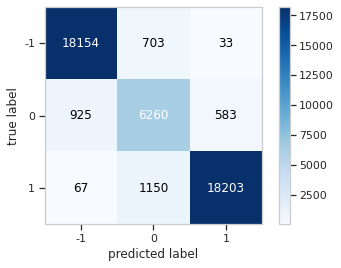

31/31 [==============================] - 0s 6ms/step - loss: 0.4008 - accuracy: 0.9337 - top2_accuracy: 0.9806


In [ ]:
# k = 10 & Model 1 with best parameter with Adam optimizer and lr = 1e-3
deeplob1.load_weights('Lei_k=10adam1e-3.h5')

# process data of the three new stocks
mid_msft, X_msft, Y_msft = prepare_x_y(df = MSFT, stock = 1, k=10, T=100, alpha=1e-4, normalization_window = 10) 
mid_bili, X_bili, Y_bili = prepare_x_y(df = BILI, stock = 2, k=10, T=100, alpha=1e-4, normalization_window = 10) 
mid_aapl, X_aapl, Y_aapl = prepare_x_y(df = AAPL, stock = 3, k=10, T=100, alpha=1e-4, normalization_window = 10) 
X = np.concatenate((X_msft, X_bili, X_aapl),axis = 0) 
Y = np.concatenate((Y_msft, Y_bili, Y_aapl),axis = 0)

# make prediction
pred = deeplob1.predict(X) 
print('This is the conditional output for k = 10') 

# get classification report
print(classification_report(Y.argmax(axis=1), pred.argmax(axis=1), digits = 4))

# plot confusion matrix
matrix = confusion_matrix(Y.argmax(axis=1), pred.argmax(axis=1))
from mlxtend.plotting import plot_confusion_matrix
fig, ax = plot_confusion_matrix(conf_mat = matrix,
                                colorbar = True,
                                show_absolute = True,
                                show_normed = False)
ax.xaxis.set_ticklabels(['?','-1', '0', '1'])
ax.yaxis.set_ticklabels(['?','-1', '0', '1'])
plt.show()

# conduct boxplot
acc = np.zeros(10)
for i in range(10):
  acc[i] = deeplob1.evaluate(X_msft[floor(len(X_msft)/10)*i : floor(len(X_msft)/10)*(i+1)],
                             Y_msft[floor(len(X_msft)/10)*i : floor(len(X_msft)/10)*(i+1)])[1]
                             
acc_aapl = np.zeros(10)
for i in range(10):
  acc_aapl[i] = deeplob1.evaluate(X_aapl[floor(len(X_aapl)/10)*i : floor(len(X_aapl)/10)*(i+1)],
                             Y_aapl[floor(len(X_aapl)/10)*i : floor(len(X_aapl)/10)*(i+1)])[1]

acc_bili = np.zeros(10)
for i in range(10):
  acc_bili[i] = deeplob1.evaluate(X_bili[floor(len(X_bili)/10)*i : floor(len(X_bili)/10)*(i+1)],
                             Y_bili[floor(len(X_bili)/10)*i : floor(len(X_bili)/10)*(i+1)])[1]

## **Prediction Horizon K = 20**

This is the conditional output for k = 20
              precision    recall  f1-score   support

           0     0.9693    0.9627    0.9660     19874
           1     0.7855    0.7974    0.7914      5621
           2     0.9701    0.9724    0.9712     20553

    accuracy                         0.9469     46048
   macro avg     0.9083    0.9108    0.9095     46048
weighted avg     0.9472    0.9469    0.9470     46048



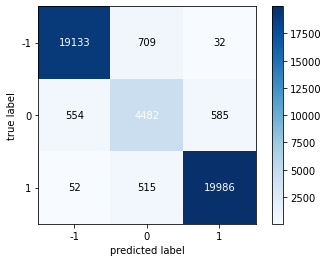

46/46 [==============================] - 0s 6ms/step - loss: 0.1280 - accuracy: 0.9583 - top2_accuracy: 0.9986


In [ ]:
# k = 20 & Model 1 with best parameter with Adam optimizer and lr = 1e-4
deeplob1.load_weights('Lei_k=20adam1e-4.h5')
mid_msft, X_msft, Y_msft = prepare_x_y(df = MSFT, stock = 1, k=20, T=100, alpha=1e-4, normalization_window = 20) 
mid_bili, X_bili, Y_bili = prepare_x_y(df = BILI, stock = 2, k=20, T=100, alpha=1e-4, normalization_window = 20) 
mid_aapl, X_aapl, Y_aapl = prepare_x_y(df = AAPL, stock = 3, k=20, T=100, alpha=1e-4, normalization_window = 20) 
X = np.concatenate((X_msft, X_bili, X_aapl),axis = 0) 
Y = np.concatenate((Y_msft, Y_bili, Y_aapl),axis = 0)

# make prediction
pred = deeplob1.predict(X) 
print('This is the conditional output for k = 20') 

# get classification report
print(classification_report(Y.argmax(axis=1), pred.argmax(axis=1), digits = 4))

# plot confusion matrix
matrix = confusion_matrix(Y.argmax(axis=1), pred.argmax(axis=1))
from mlxtend.plotting import plot_confusion_matrix
fig, ax = plot_confusion_matrix(conf_mat = matrix,
                                colorbar = True,
                                show_absolute = True,
                                show_normed = False)
ax.xaxis.set_ticklabels(['?','-1', '0', '1'])
ax.yaxis.set_ticklabels(['?','-1', '0', '1'])
plt.show()

# conduct boxplot
acc_msft_k20 = np.zeros(10)
for i in range(10):
  acc_msft_k20[i] = deeplob1.evaluate(X_msft[floor(len(X_msft)/10)*i : floor(len(X_msft)/10)*(i+1)],
                             Y_msft[floor(len(X_msft)/10)*i : floor(len(X_msft)/10)*(i+1)])[1]

acc_bili_k20 = np.zeros(10)
for i in range(10):
  acc_bili_k20[i] = deeplob1.evaluate(X_bili[floor(len(X_bili)/10)*i : floor(len(X_bili)/10)*(i+1)],
                             Y_bili[floor(len(X_bili)/10)*i : floor(len(X_bili)/10)*(i+1)])[1]
                             
acc_aapl_k20 = np.zeros(10)
for i in range(10):
  acc_aapl_k20[i] = deeplob1.evaluate(X_aapl[floor(len(X_aapl)/10)*i : floor(len(X_aapl)/10)*(i+1)],
                             Y_aapl[floor(len(X_aapl)/10)*i : floor(len(X_aapl)/10)*(i+1)])[1]

## **Prediction Horizon K = 50**

This is the conditional output for k = 50
              precision    recall  f1-score   support

           0     0.9605    0.9753    0.9679     20353
           1     0.6686    0.7257    0.6960      3759
           2     0.9804    0.9519    0.9659     21846

    accuracy                         0.9438     45958
   macro avg     0.8698    0.8843    0.8766     45958
weighted avg     0.9461    0.9438    0.9447     45958



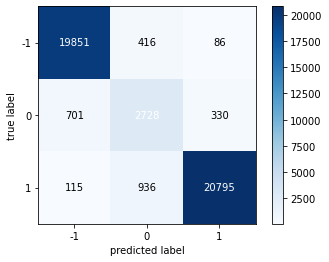

31/31 [==============================] - 0s 6ms/step - loss: 0.1828 - accuracy: 0.9631 - top2_accuracy: 0.9836


In [ ]:
# k = 50 & Model 1 with best parameter with Adam optimizer and lr = 1e-4
deeplob1.load_weights('Lei_k=50adam1e-4.h5')
mid_msft, X_msft, Y_msft = prepare_x_y(df = MSFT, stock = 1, k=50, T=100, alpha=1e-4, normalization_window = 50) 
mid_bili, X_bili, Y_bili = prepare_x_y(df = BILI, stock = 2, k=50, T=100, alpha=1e-4, normalization_window = 50) 
mid_aapl, X_aapl, Y_aapl = prepare_x_y(df = AAPL, stock = 3, k=50, T=100, alpha=1e-4, normalization_window = 50) 
X = np.concatenate((X_msft, X_bili, X_aapl),axis = 0) 
Y = np.concatenate((Y_msft, Y_bili, Y_aapl),axis = 0)

# make prediction
pred = deeplob1.predict(X) 
print('This is the conditional output for k = 50') 

# get classification report
print(classification_report(Y.argmax(axis=1), pred.argmax(axis=1), digits = 4))

# plot confusion matrix
matrix = confusion_matrix(Y.argmax(axis=1), pred.argmax(axis=1))
from mlxtend.plotting import plot_confusion_matrix
fig, ax = plot_confusion_matrix(conf_mat = matrix,
                                colorbar = True,
                                show_absolute = True,
                                show_normed = False)
ax.xaxis.set_ticklabels(['?','-1', '0', '1'])
ax.yaxis.set_ticklabels(['?','-1', '0', '1'])
plt.show()

# conduct boxplot
acc_aapl_k50 = np.zeros(10)
for i in range(10):
  acc_aapl_k50[i] = deeplob1.evaluate(X_aapl[floor(len(X_aapl)/10)*i : floor(len(X_aapl)/10)*(i+1)],
                             Y_aapl[floor(len(X_aapl)/10)*i : floor(len(X_aapl)/10)*(i+1)])[1]

acc_msft_k50 = np.zeros(10)
for i in range(10):
  acc_msft_k50[i] = deeplob1.evaluate(X_msft[floor(len(X_msft)/10)*i : floor(len(X_msft)/10)*(i+1)],
                             Y_msft[floor(len(X_msft)/10)*i : floor(len(X_msft)/10)*(i+1)])[1]

acc_bili_k50 = np.zeros(10)
for i in range(10):
  acc_bili_k50[i] = deeplob1.evaluate(X_bili[floor(len(X_bili)/10)*i : floor(len(X_bili)/10)*(i+1)],
                             Y_bili[floor(len(X_bili)/10)*i : floor(len(X_bili)/10)*(i+1)])[1]

## **Boxplot of Model 1**

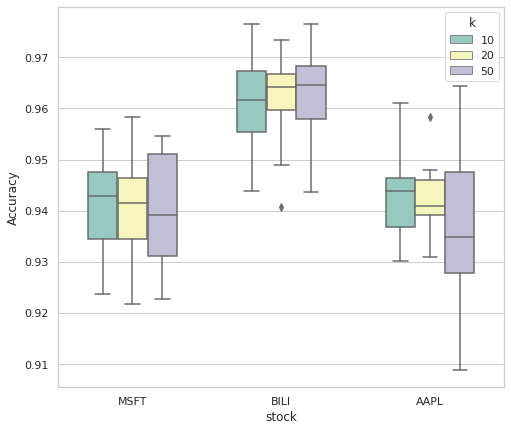

In [ ]:
# put the boxplot results together and visulize them
acc_df = pd.DataFrame({'Accuracy': acc, 'stock': 'MSFT', 'k': 10})
acc_df = acc_df.append(pd.DataFrame({'Accuracy': acc_msft_k20, 'stock': 'MSFT', 'k': 20}), ignore_index = True)
acc_df = acc_df.append(pd.DataFrame({'Accuracy': acc_msft_k50, 'stock': 'MSFT', 'k': 50}), ignore_index = True)
acc_df = acc_df.append(pd.DataFrame({'Accuracy': acc_bili, 'stock': 'BILI', 'k': 10}), ignore_index = True)
acc_df = acc_df.append(pd.DataFrame({'Accuracy': acc_bili_k20, 'stock': 'BILI', 'k': 20}), ignore_index = True)
acc_df = acc_df.append(pd.DataFrame({'Accuracy': acc_bili_k50, 'stock': 'BILI', 'k': 50}), ignore_index = True)
acc_df = acc_df.append(pd.DataFrame({'Accuracy': acc_aapl, 'stock': 'AAPL', 'k': 10}), ignore_index = True)
acc_df = acc_df.append(pd.DataFrame({'Accuracy': acc_aapl_k20, 'stock': 'AAPL', 'k': 20}), ignore_index = True)
acc_df = acc_df.append(pd.DataFrame({'Accuracy': acc_aapl_k50, 'stock': 'AAPL', 'k': 50}), ignore_index = True)


import seaborn as sns
plt.figure(figsize = (8,7))
sns.set_theme(style="whitegrid")
ax = sns.boxplot(x = 'stock', y = 'Accuracy', hue = 'k', data = acc_df, palette = 'Set3',width = 0.6)

# **Confusion Matrix and Boxplot for Model 2**

## **Define Model 1**

In [ ]:
def create_deeplob2(T, NF):
    input_lmd = Input(shape=(T, NF,1))
    
    # build the convolutional block
    conv_first1 = Conv2D(16, (4, 40))(input_lmd)
    conv_first1 = keras.layers.LeakyReLU(alpha=0.01)(conv_first1)
    conv_first1 = Conv2D(16, (4,1), padding='same')(conv_first1)
    conv_first1 = keras.layers.LeakyReLU(alpha=0.01)(conv_first1)
    conv_first1 = MaxPooling2D((2,1), padding='same')(conv_first1)

    conv_first1 = Conv2D(32, (3,1), padding='same')(conv_first1)
    conv_first1 = keras.layers.LeakyReLU(alpha=0.01)(conv_first1)
    conv_first1 = Conv2D(32, (3,1), padding='same')(conv_first1)
    conv_first1 = keras.layers.LeakyReLU(alpha=0.01)(conv_first1)
    conv_first1 = MaxPooling2D((2,1), padding='same')(conv_first1)

    conv = Flatten()(conv_first1)
    conv = Dropout(0.2)(conv)
    conv = Dense(32)(conv)
    out = Dense(3, activation = 'softmax')(conv)

    model = Model(inputs=input_lmd, outputs=out)
    model.compile(optimizer = tf.keras.optimizers.Adam(lr = 1e-4),
                  loss='categorical_crossentropy',
                  metrics=['accuracy',
                           tf.keras.metrics.TopKCategoricalAccuracy(k=2, name='top2_accuracy')])

    return model
    
deeplob2 = create_deeplob2(100, 40)
deeplob2.summary()


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 100, 40, 1)]      0         
                                                                 
 conv2d_14 (Conv2D)          (None, 97, 1, 16)         2576      
                                                                 
 leaky_re_lu_14 (LeakyReLU)  (None, 97, 1, 16)         0         
                                                                 
 conv2d_15 (Conv2D)          (None, 97, 1, 16)         1040      
                                                                 
 leaky_re_lu_15 (LeakyReLU)  (None, 97, 1, 16)         0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 49, 1, 16)        0         
 2D)                                                             
                                                           

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


## **Prediction Horizon K = 10**

This is the conditional output for k = 10
              precision    recall  f1-score   support

           0     0.9493    0.9606    0.9549     18890
           1     0.8097    0.7497    0.7786      7768
           2     0.9447    0.9618    0.9532     19420

    accuracy                         0.9255     46078
   macro avg     0.9012    0.8907    0.8955     46078
weighted avg     0.9238    0.9255    0.9244     46078



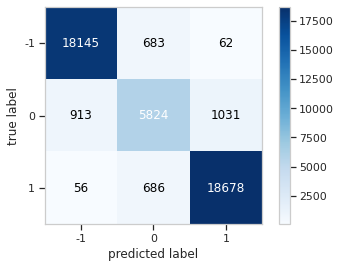

31/31 [==============================] - 0s 2ms/step - loss: 0.1652 - accuracy: 0.9327 - top2_accuracy: 0.9847


In [ ]:
deeplob2.load_weights('cy1_adam-4.h5')
mid_msft, X_msft, Y_msft = prepare_x_y(df = MSFT, stock = 1, k=10, T=100, alpha=1e-4, normalization_window = 10) 
mid_bili, X_bili, Y_bili = prepare_x_y(df = BILI, stock = 2, k=10, T=100, alpha=1e-4, normalization_window = 10) 
mid_aapl, X_aapl, Y_aapl = prepare_x_y(df = AAPL, stock = 3, k=10, T=100, alpha=1e-4, normalization_window = 10) 
X = np.concatenate((X_msft, X_bili, X_aapl),axis = 0) 
Y = np.concatenate((Y_msft, Y_bili, Y_aapl),axis = 0)

pred = deeplob2.predict(X) 
print('This is the conditional output for k = 10') 

# get classification report
print(classification_report(Y.argmax(axis=1), pred.argmax(axis=1), digits = 4))

# plot confusion matrix
matrix = confusion_matrix(Y.argmax(axis=1), pred.argmax(axis=1))
from mlxtend.plotting import plot_confusion_matrix
fig, ax = plot_confusion_matrix(conf_mat = matrix,
                                colorbar = True,
                                show_absolute = True,
                                show_normed = False)
ax.xaxis.set_ticklabels(['?','-1', '0', '1'])
ax.yaxis.set_ticklabels(['?','-1', '0', '1'])
plt.show()

# conduct boxplot
acc = np.zeros(10)
for i in range(10):
  acc[i] = deeplob2.evaluate(X_msft[floor(len(X_msft)/10)*i : floor(len(X_msft)/10)*(i+1)],
                             Y_msft[floor(len(X_msft)/10)*i : floor(len(X_msft)/10)*(i+1)])[1]
                             
acc_aapl = np.zeros(10)
for i in range(10):
  acc_aapl[i] = deeplob2.evaluate(X_aapl[floor(len(X_aapl)/10)*i : floor(len(X_aapl)/10)*(i+1)],
                             Y_aapl[floor(len(X_aapl)/10)*i : floor(len(X_aapl)/10)*(i+1)])[1]

acc_bili = np.zeros(10)
for i in range(10):
  acc_bili[i] = deeplob2.evaluate(X_bili[floor(len(X_bili)/10)*i : floor(len(X_bili)/10)*(i+1)],
                             Y_bili[floor(len(X_bili)/10)*i : floor(len(X_bili)/10)*(i+1)])[1]

## **Prediction Horizon K = 20**

This is the conditional output for k = 20
              precision    recall  f1-score   support

           0     0.9644    0.9730    0.9687     19874
           1     0.7883    0.7810    0.7846      5621
           2     0.9738    0.9678    0.9708     20553

    accuracy                         0.9473     46048
   macro avg     0.9088    0.9073    0.9080     46048
weighted avg     0.9471    0.9473    0.9472     46048



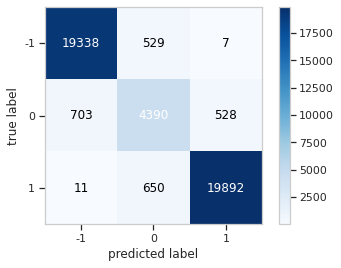

46/46 [==============================] - 0s 2ms/step - loss: 0.1368 - accuracy: 0.9460 - top2_accuracy: 0.9993


In [ ]:
deeplob2.load_weights('cy2_adam-4.h5')
mid_msft, X_msft, Y_msft = prepare_x_y(df = MSFT, stock = 1, k=20, T=100, alpha=1e-4, normalization_window = 20) 
mid_bili, X_bili, Y_bili = prepare_x_y(df = BILI, stock = 2, k=20, T=100, alpha=1e-4, normalization_window = 20) 
mid_aapl, X_aapl, Y_aapl = prepare_x_y(df = AAPL, stock = 3, k=20, T=100, alpha=1e-4, normalization_window = 20) 
X = np.concatenate((X_msft, X_bili, X_aapl),axis = 0) 
Y = np.concatenate((Y_msft, Y_bili, Y_aapl),axis = 0)

# make prediction
pred = deeplob2.predict(X) 
print('This is the conditional output for k = 20') 

# get classification report
print(classification_report(Y.argmax(axis=1), pred.argmax(axis=1), digits = 4))

# plot confusion matrix
matrix = confusion_matrix(Y.argmax(axis=1), pred.argmax(axis=1))
from mlxtend.plotting import plot_confusion_matrix
fig, ax = plot_confusion_matrix(conf_mat = matrix,
                                colorbar = True,
                                show_absolute = True,
                                show_normed = False)
ax.xaxis.set_ticklabels(['?','-1', '0', '1'])
ax.yaxis.set_ticklabels(['?','-1', '0', '1'])
plt.show()

# conduct boxplot
acc_msft_k20 = np.zeros(10)
for i in range(10):
  acc_msft_k20[i] = deeplob2.evaluate(X_msft[floor(len(X_msft)/10)*i : floor(len(X_msft)/10)*(i+1)],
                             Y_msft[floor(len(X_msft)/10)*i : floor(len(X_msft)/10)*(i+1)])[1]

acc_bili_k20 = np.zeros(10)
for i in range(10):
  acc_bili_k20[i] = deeplob2.evaluate(X_bili[floor(len(X_bili)/10)*i : floor(len(X_bili)/10)*(i+1)],
                             Y_bili[floor(len(X_bili)/10)*i : floor(len(X_bili)/10)*(i+1)])[1]
                             
acc_aapl_k20 = np.zeros(10)
for i in range(10):
  acc_aapl_k20[i] = deeplob2.evaluate(X_aapl[floor(len(X_aapl)/10)*i : floor(len(X_aapl)/10)*(i+1)],
                             Y_aapl[floor(len(X_aapl)/10)*i : floor(len(X_aapl)/10)*(i+1)])[1]

## **Prediction Horizon K = 50**

This is the conditional output for k = 50
              precision    recall  f1-score   support

           0     0.9735    0.9726    0.9730     20353
           1     0.7453    0.7334    0.7393      3759
           2     0.9763    0.9799    0.9781     21846

    accuracy                         0.9565     45958
   macro avg     0.8984    0.8953    0.8968     45958
weighted avg     0.9562    0.9565    0.9563     45958



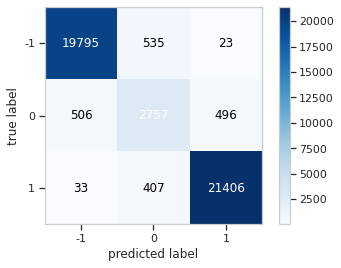

31/31 [==============================] - 0s 3ms/step - loss: 0.0751 - accuracy: 0.9734 - top2_accuracy: 0.9928


In [ ]:
deeplob2.load_weights('cy5_adam-4.h5')
mid_msft, X_msft, Y_msft = prepare_x_y(df = MSFT, stock = 1, k=50, T=100, alpha=1e-4, normalization_window = 50) 
mid_bili, X_bili, Y_bili = prepare_x_y(df = BILI, stock = 2, k=50, T=100, alpha=1e-4, normalization_window = 50) 
mid_aapl, X_aapl, Y_aapl = prepare_x_y(df = AAPL, stock = 3, k=50, T=100, alpha=1e-4, normalization_window = 50) 
X = np.concatenate((X_msft, X_bili, X_aapl),axis = 0) 
Y = np.concatenate((Y_msft, Y_bili, Y_aapl),axis = 0)

# make prediction
pred = deeplob2.predict(X) 
print('This is the conditional output for k = 50') 

# get classification report
print(classification_report(Y.argmax(axis=1), pred.argmax(axis=1), digits = 4))

# plot confusion matrix
matrix = confusion_matrix(Y.argmax(axis=1), pred.argmax(axis=1))
from mlxtend.plotting import plot_confusion_matrix
fig, ax = plot_confusion_matrix(conf_mat = matrix,
                                colorbar = True,
                                show_absolute = True,
                                show_normed = False)
ax.xaxis.set_ticklabels(['?','-1', '0', '1'])
ax.yaxis.set_ticklabels(['?','-1', '0', '1'])
plt.show()

# conduct boxplot
acc_aapl_k50 = np.zeros(10)
for i in range(10):
  acc_aapl_k50[i] = deeplob2.evaluate(X_aapl[floor(len(X_aapl)/10)*i : floor(len(X_aapl)/10)*(i+1)],
                             Y_aapl[floor(len(X_aapl)/10)*i : floor(len(X_aapl)/10)*(i+1)])[1]

acc_msft_k50 = np.zeros(10)
for i in range(10):
  acc_msft_k50[i] = deeplob2.evaluate(X_msft[floor(len(X_msft)/10)*i : floor(len(X_msft)/10)*(i+1)],
                             Y_msft[floor(len(X_msft)/10)*i : floor(len(X_msft)/10)*(i+1)])[1]

acc_bili_k50 = np.zeros(10)
for i in range(10):
  acc_bili_k50[i] = deeplob2.evaluate(X_bili[floor(len(X_bili)/10)*i : floor(len(X_bili)/10)*(i+1)],
                             Y_bili[floor(len(X_bili)/10)*i : floor(len(X_bili)/10)*(i+1)])[1]

## **Boxplot of Model 2**

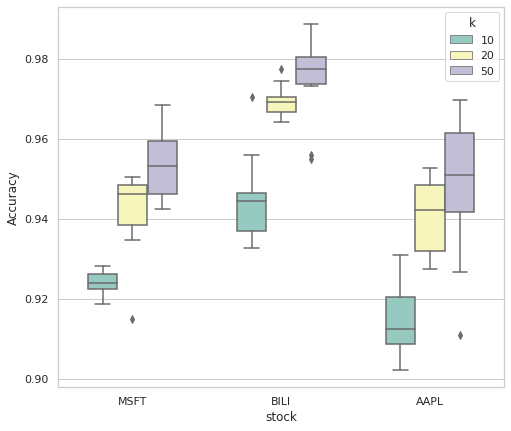

In [ ]:
acc_df = pd.DataFrame({'Accuracy': acc, 'stock': 'MSFT', 'k': 10})
acc_df = acc_df.append(pd.DataFrame({'Accuracy': acc_msft_k20, 'stock': 'MSFT', 'k': 20}), ignore_index = True)
acc_df = acc_df.append(pd.DataFrame({'Accuracy': acc_msft_k50, 'stock': 'MSFT', 'k': 50}), ignore_index = True)
acc_df = acc_df.append(pd.DataFrame({'Accuracy': acc_bili, 'stock': 'BILI', 'k': 10}), ignore_index = True)
acc_df = acc_df.append(pd.DataFrame({'Accuracy': acc_bili_k20, 'stock': 'BILI', 'k': 20}), ignore_index = True)
acc_df = acc_df.append(pd.DataFrame({'Accuracy': acc_bili_k50, 'stock': 'BILI', 'k': 50}), ignore_index = True)
acc_df = acc_df.append(pd.DataFrame({'Accuracy': acc_aapl, 'stock': 'AAPL', 'k': 10}), ignore_index = True)
acc_df = acc_df.append(pd.DataFrame({'Accuracy': acc_aapl_k20, 'stock': 'AAPL', 'k': 20}), ignore_index = True)
acc_df = acc_df.append(pd.DataFrame({'Accuracy': acc_aapl_k50, 'stock': 'AAPL', 'k': 50}), ignore_index = True)


import seaborn as sns
plt.figure(figsize = (8,7))
sns.set_theme(style="whitegrid")
ax = sns.boxplot(x = 'stock', y = 'Accuracy', hue = 'k', data = acc_df, palette = 'Set3',width = 0.6)

# **Confusion Matrix and Boxplot on Model 3 are in another Notebook**